# AI-LAB LESSON 4: Markov Decision Process

In the third session we will work on the Markov decision process (MDP)

## Lava environments
The environments used are LavaFloor (visible in the figure) and its variations.

![Lava](images/lava.png)

The agent starts in cell $(0, 0)$ and has to reach the treasure in $(2, 3)$. In addition to the walls of the previous environments, the floor is covered with lava, there is a black pit of death.

Moreover, the agent can't comfortably perform its actions that instead have a stochastic outcome (visible in the figure):

![Dynact](images/dynact.png)

The action dynamics is the following:
- $P(0.8)$ of moving in the desired direction
- $P(0.1)$ of moving in a direction 90° with respect to the desired direction

Finally, since the floor is covered in lava, the agent receives a negative reward for each of its steps!

- -0.04 for each lava cell (L)
- -5 for the black pit (P). End of episode
- +1 for the treasure (G). End of episode

In [1]:
import os, sys, random
module_path = os.path.abspath(os.path.join('../tools'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gym, envs
from utils.ai_lab_functions import *
from timeit import default_timer as timer
from tqdm import tqdm as tqdm

### Environment Properties 

In addition to the varables of the environments you have been using in the previous sessions, there are also a few more:

- $T$: matrix of the transition function $T(s, a, s') \rightarrow [0, 1]$
- $RS$: matrix of the reward function $R(s) \rightarrow \mathbb{R}$

The available actions are still Left, Right, Up, Down.

#### Code Hints:

In [2]:
env = gym.make("VeryBadLavaFloor-v0")

current_state = env.pos_to_state(0, 0)
next_state = env.pos_to_state(0, 1)
goal_state = env.pos_to_state(2, 3)

print("Number of actions: ", env.action_space.n)
print("Actions: ", env.actions)
print("Reward of starting state:", env.RS[current_state])
print("Reward of goal state:", env.RS[goal_state])
print("Probability from (0, 0) to (1, 0) with action left:", env.T[current_state, 1, next_state])
print("Probability from (0, 0) to (2, 3) with action left:", env.T[current_state, 1, goal_state])

Number of actions:  4
Actions:  {0: 'L', 1: 'R', 2: 'U', 3: 'D'}
Reward of starting state: -5.0
Reward of goal state: 1.0
Probability from (0, 0) to (1, 0) with action left: 0.8
Probability from (0, 0) to (2, 3) with action left: 0.0


In [3]:
env = gym.make("VeryBadLavaFloor-v0")

current_state = env.pos_to_state(0, 0)
stato = env.sample(current_state, 0)
print(stato)

print(env.T[current_state, 0, stato])
print(env.T[current_state, 1, stato])
print(env.T[current_state, 2, stato])
print(env.T[current_state, 3, stato])

0
0.9
0.1
0.9
0.1


In [4]:
def best_action_from_state(state, environment, U, policy):
    
    best_action = 0
    best_reward = 0
    
    #se la policy e' uguale a 0 allora mi baso sulla bellman equation prendendo il massimo 
    #su tutte le possibili azioni
    if(policy == 0):
        
        #controllo se sono alla prima iterazione init=1
        # in questo caso dovro' inizializzare il best_reward per il confronto
        init = 1
        
        for action in range(environment.action_space.n):
            
            reward = 0
            for next_state in range(environment.observation_space.n):
                reward += environment.T[state, action, next_state] * U[next_state]

            if init or reward > best_reward:
                best_reward = reward
                best_action = action
                
            init =0
            
    #se invece passo un parametro policy, implemento la bellman equation con l'azione che mi da la policy
    else:
        
        for next_state in range(environment.observation_space.n):
            best_reward += environment.T[state, policy[state], next_state] * U[next_state]

    return best_action, best_reward


### Assignment 1: Value Iteration Algorithm

Your first assignment is to implement the Value Iteration algorithm on LavaFloor. The solution returned by your algorithm must be a 1-d array of action identifiers where the $i$-th action refers to the $i$-th state.  You can perform all the test on a different versions of the environment, but with the same structure: *HugeLavaFloor*, *NiceLavaFloor* and *VeryBadLavaFloor*.

<img src="images/value-iteration.png" width="600">

The *value_iteration* function has to be implemented. Notice that the value iteration approach return a matrix with the value for eacht state, the function *values_to_policy* automatically convert this matrix in the policy.

In [5]:
def value_iteration(environment, maxiters=300, discount=0.9, max_error=1e-3):
    """
    Performs the value iteration algorithm for a specific environment
    
    Args:
        environment: OpenAI Gym environment
        maxiters: timeout for the iterations
        discount: gamma value, the discount factor for the Bellman equation
        max_error: the maximum error allowd in the utility of any state
        
    Returns:
        policy: 1-d dimensional array of action identifiers where index `i` corresponds to state id `i`
    """
    
    U_1 = [0 for _ in range(environment.observation_space.n)] # vettore delle utilita'
    delta = 0 # mi segna il cambiamento che ho avuto con l'update
    
    
    for _ in range(maxiters):
        delta = 0
        U = U_1.copy()
        
        for state in range(environment.observation_space.n):      

            action, best_reward = best_action_from_state(state, environment , U, 0)
            U_1[state] = environment.RS[state] + discount * best_reward
            
            diff=abs(U_1[state] - U[state])
            
            if diff > delta :
                delta = diff
                
        if delta < (max_error *(1.0-discount) /discount):
            break
    #
    #
    
    return values_to_policy(np.asarray(U), env) # converte automaticamente i valori della matricce U in una policy 

The following code executes and Value Iteration and prints the resulting policy

In [6]:
envname = "LavaFloor-v0"
#envname = "HugeLavaFloor-v0"
#envname = "NiceLavaFloor-v0"
#envname = "VeryBadLavaFloor-v0"

print("\n----------------------------------------------------------------")
print("\tEnvironment: {} \n\tValue Iteration".format(envname))
print("----------------------------------------------------------------")

env = gym.make(envname)
print("\nRENDER:")
env.render()

t = timer()
policy = value_iteration(env)

print("\nTIME: \n{}".format(round(timer() - t, 4)))
print("\nPOLICY:")
print(np.vectorize(env.actions.get)(policy.reshape(env.rows, env.cols)))


----------------------------------------------------------------
	Environment: LavaFloor-v0 
	Value Iteration
----------------------------------------------------------------

RENDER:
[['S' 'L' 'L' 'L']
 ['L' 'W' 'L' 'P']
 ['L' 'L' 'L' 'G']]

TIME: 
0.0558

POLICY:
[['D' 'L' 'L' 'U']
 ['D' 'L' 'L' 'L']
 ['R' 'R' 'R' 'L']]


Correct results can be found [here](lesson_4_results.txt).

### Assignment 2: Policy Iteration Algorithm

Your first assignment is to implement the Policy Iteration algorithm on LavaFloor. The solution returned by your algorithm must be a 1-d array of action identifiers where the $i$-th action refers to the $i$-th state. You can perform all the test on a different versions of the environment, but with the same structure: *HugeLavaFloor*, *NiceLavaFloor* and *VeryBadLavaFloor*.

<img src="images/policy-iteration.png" width="600">

For the *policy evaluation step*, it is necessary to implement this function:

<img src="images/policy-evaluating.png" width="500">

The following function has to be implemented:

In [7]:
def policy_iteration(environment, maxiters=150, discount=0.9, maxviter=10):
    """
    Performs the policy iteration algorithm for a specific environment
    
    Args:
        environment: OpenAI Gym environment
        maxiters: timeout for the iterations
        discount: gamma value, the discount factor for the Bellman equation
        
    Returns:
        policy: 1-d dimensional array of action identifiers where index `i` corresponds to state id `i`
    """
    
    policy = [0 for _ in range(environment.observation_space.n)] #inizializzo il vettore delle policy
    U = [0 for _ in range(environment.observation_space.n)] #vettore delle utilita'
    
    
    unchanged = False #se non ho piu' cambiamento = False
    
    while not unchanged and maxiters:

        unchanged = True
        maxiters -=1
        
        # Step (1): Policy Evaluation
        
        for _ in range(maxviter):
            for state in range(environment.observation_space.n):
                _, policy_rew = best_action_from_state(state, environment , U, policy)
                U[state] = env.RS[state] + discount *policy_rew
        
        # Step (2) Policy Improvement
        
        for state in range(environment.observation_space.n):
            
            best_action, best_action_reward = best_action_from_state(state, environment, U,0)
            
            # reward atteso della policy
            policy_reward = 0
            for next_state in range(environment.observation_space.n):
                policy_reward += environment.T[current_state, policy[state], next_state] * U[next_state]

            # confronta con il reward atteso seguendo la policy
            if best_action_reward > policy_reward:
                policy[state] = best_action
                unchanged = False
    
    return np.asarray(policy)

The following code executes and Value Iteration and prints the resulting policy

In [8]:
envname = "LavaFloor-v0"
#envname = "HugeLavaFloor-v0"
#envname = "NiceLavaFloor-v0"
#envname = "VeryBadLavaFloor-v0"

print("\n----------------------------------------------------------------")
print("\tEnvironment: {} \n\tPolicy Iteration".format(envname))
print("----------------------------------------------------------------")

env = gym.make(envname)
print("\nRENDER:")
env.render()

t = timer()
policy = policy_iteration(env)

print("\nTIME: \n{}".format(round(timer() - t, 4)))
print("\nPOLICY:")
print(np.vectorize(env.actions.get)(policy.reshape(env.rows, env.cols)))


----------------------------------------------------------------
	Environment: LavaFloor-v0 
	Policy Iteration
----------------------------------------------------------------

RENDER:
[['S' 'L' 'L' 'L']
 ['L' 'W' 'L' 'P']
 ['L' 'L' 'L' 'G']]

TIME: 
0.3601

POLICY:
[['D' 'L' 'D' 'L']
 ['D' 'L' 'L' 'L']
 ['R' 'R' 'R' 'L']]


Correct results can be found [here](lesson_4_results.txt).

### Comparison

The following code performs a comparison between Value Iteration and Policy Iteration, by plotting the accumulated rewards of each episode with iterations in range $[1, 50]$ (might take a long time if not optimizied via numpy). You can perform all the test on a different versions of the environment, but with the same structure: *HugeLavaFloor*.

The function **run_episode(envirnonment, policy, max_iteration)** run an episode on the given environment using the input policy.

Policy Iteration: 100%|█████████████████████████| 50/50 [00:03<00:00, 14.38it/s]


Execution time: 5.0763s


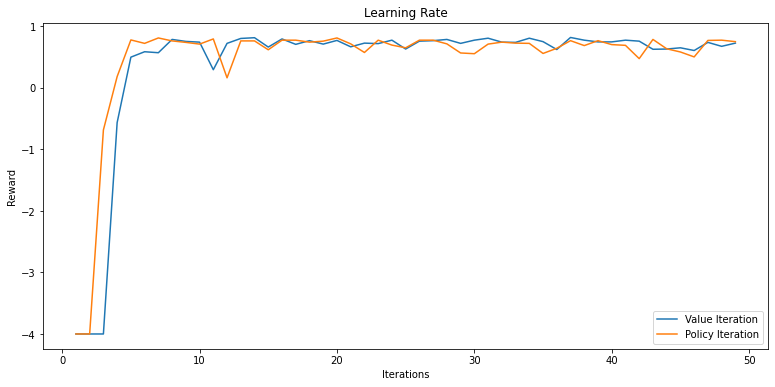

In [9]:
envname = "LavaFloor-v0"
#envname = "HugeLavaFloor-v0"
#envname = "NiceLavaFloor-v0"
#envname = "VeryBadLavaFloor-v0"

maxiters = 49

env = gym.make(envname)

series = []  # Series of learning rates to plot
liters = np.arange(maxiters + 1)  # Learning iteration values
liters[0] = 1
elimit = 100  # Limit of steps per episode
rep = 10  # Number of repetitions per iteration value
virewards = np.zeros(len(liters))  # Rewards array
c = 0
gamma = 0.9

t = timer()

# Value iteration
for i in tqdm(liters, desc="Value Iteration", leave=True):
    reprew = 0
    policy = value_iteration(env, maxiters=i)  # Compute policy
        
    # Repeat multiple times and compute mean reward
    for _ in range(rep):
        reprew += run_episode(env, policy, elimit)  # Execute policy
    virewards[c] = reprew / rep
    c += 1
series.append({"x": liters, "y": virewards, "ls": "-", "label": "Value Iteration"})


vmaxiters = 10  # Max number of iterations to perform while evaluating a policy
pirewards = np.zeros(len(liters))  # Rewards array
c = 0

# Policy iteration
for i in tqdm(liters, desc="Policy Iteration", leave=True):
    reprew = 0
    policy = policy_iteration(env, i, gamma, vmaxiters)  # Compute policy
    # Repeat multiple times and compute mean reward
    for _ in range(rep):
        reprew += run_episode(env, policy, elimit)  # Execute policy
    pirewards[c] = reprew / rep
    c += 1
series.append({"x": liters, "y": pirewards, "ls": "-", "label": "Policy Iteration"})

print("Execution time: {0}s".format(round(timer() - t, 4)))
np.set_printoptions(linewidth=10000)

plot(series, "Learning Rate", "Iterations", "Reward")

Correct results for comparison can be found here below. Notice that since the executions are stochastic the charts could differ: the important thing is the global trend and the final convergence to an optimal solution.

**Standard Lava floor results comparison**
<img src="images/results-standard.png" width="600">

**Huge Lava floor results comparison** 
<img src="images/results-huge.png" width="600">